In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import cProfile
from bayesian_changepoint_detection.generate_data import generate_normal_time_series
from bayesian_changepoint_detection import offline_changepoint_detection as offcd
from functools import partial

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


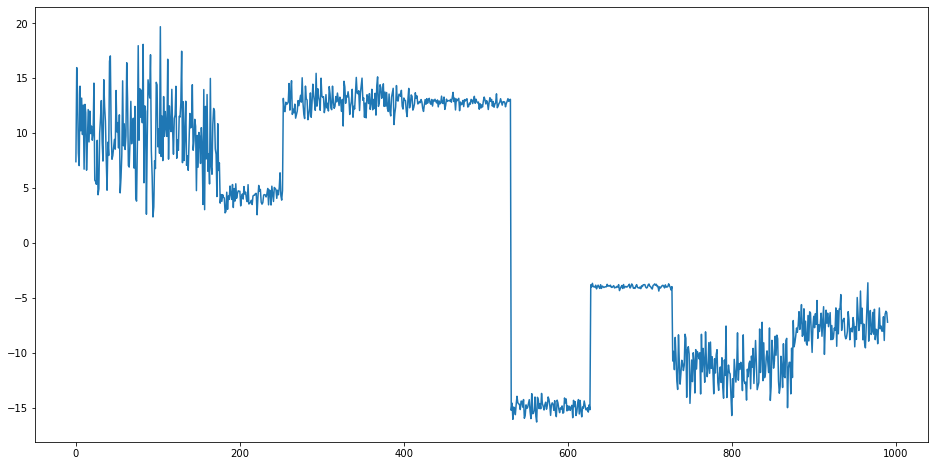

In [4]:
# Generating the data using the normal distribution where the no. of change point is '8'
partition, data = generate_normal_time_series(8, 50,200)

fig, ax = plt.subplots(figsize=(16,8)) # Plot the generated data 
ax.plot(data)

###### Here we can visualise the 7 chagepoints in the above figure

## Offline Changepoint Detection
Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance t. The second thing is a model of the likelihood of data in a sequence [s, t] of the data, given that in this sequence there is no changepoint.

For this example we assume a uniform prior over the length of sequences (const_prior) and a piecewise gaussian model (gaussian_obs_log_likelihood).

In [5]:
# Import the `const_prior` function from the `bayesian_changepoint_detection.priors` module
from bayesian_changepoint_detection.priors import const_prior

# Import the `partial` function from the `functools` module
from functools import partial

# Create a partial function `prior_function` using `const_prior` with a fixed value for the parameter `p`
# The value of `p` is calculated as `1/(len(data) + 1)` where `len(data)` is the length of a data sequence that is not shown in the code
prior_function = partial(const_prior, p=1/(len(data) + 1))


The purpose of `prior_function` is to define a prior probability distribution over the parameters of a Bayesian changepoint detection model
The `const_prior` function is a simple prior that assigns equal probability to all possible values of the parameter
prior_function` sets the value of `p` so that the prior is normalized (i.e., sums to 1) over all possible values of the parameter given the length of the data sequence

Bayesian changepoint detection is a method for detecting changes in the statistical properties of a time series
It uses a Bayesian approach to estimate the probability of a changepoint at each time step, and updates this probability as new data is observed
asciiThe prior distribution over the parameters determines the initial belief about the probability of a changepoint, and is updated using Bayes' rule as new data is observed


In [6]:
# Import the `offline_changepoint_detection` function from the `bayesian_changepoint_detection.bayesian_models` module
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection

# Import the `offline_likelihoods` module from the `bayesian_changepoint_detection` package and give it an alias of `offline_ll`
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

# Call the `offline_changepoint_detection` function with the following arguments:
# - `data`: the time series data to be analyzed
# - `prior_function`: the prior probability distribution over the parameters of the model
# - `distribution`: the likelihood function to use
# - `truncate= int `: the number of past time steps to consider when computing the likelihood, with values further in the past given exponentially less weight
Q, P, Pcp = offline_changepoint_detection(data, prior_function, offline_ll.StudentT(), truncate=-40)


Use scipy logsumexp().


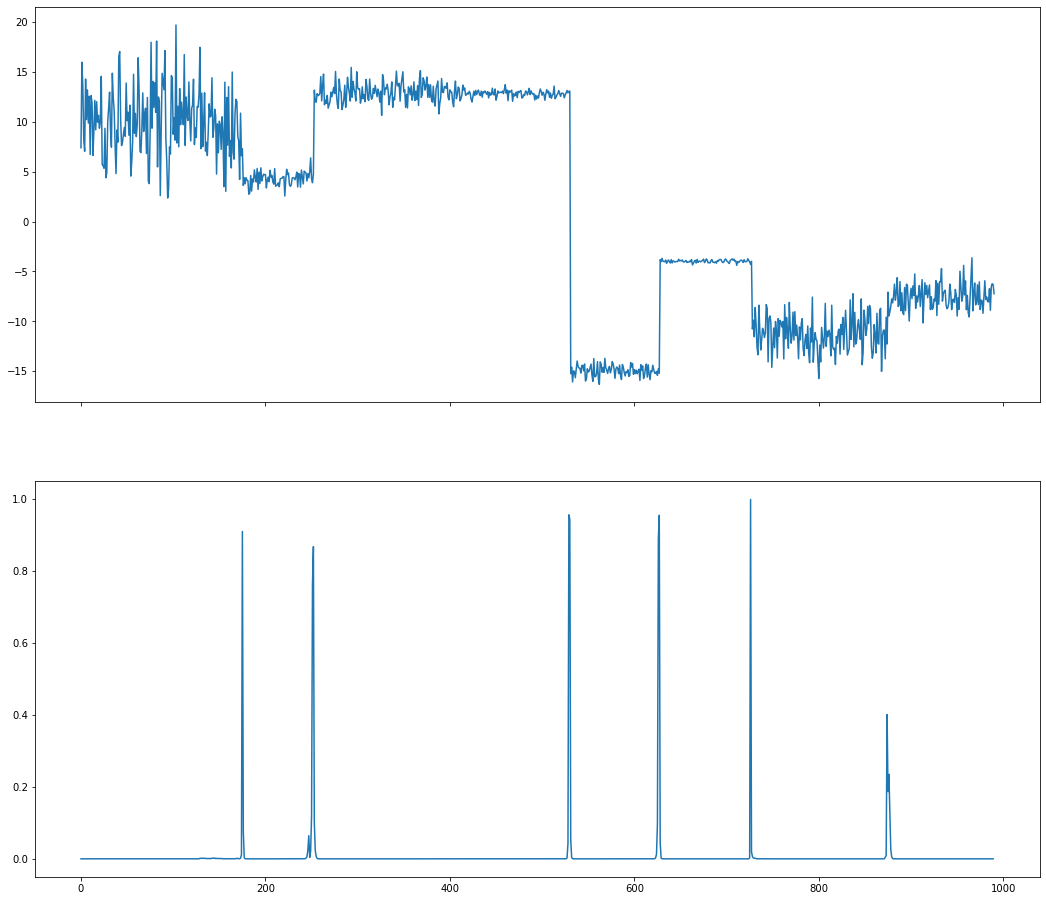

In [7]:
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
ax[0].plot(data[:])
ax[1].plot(np.exp(Pcp).sum(0))

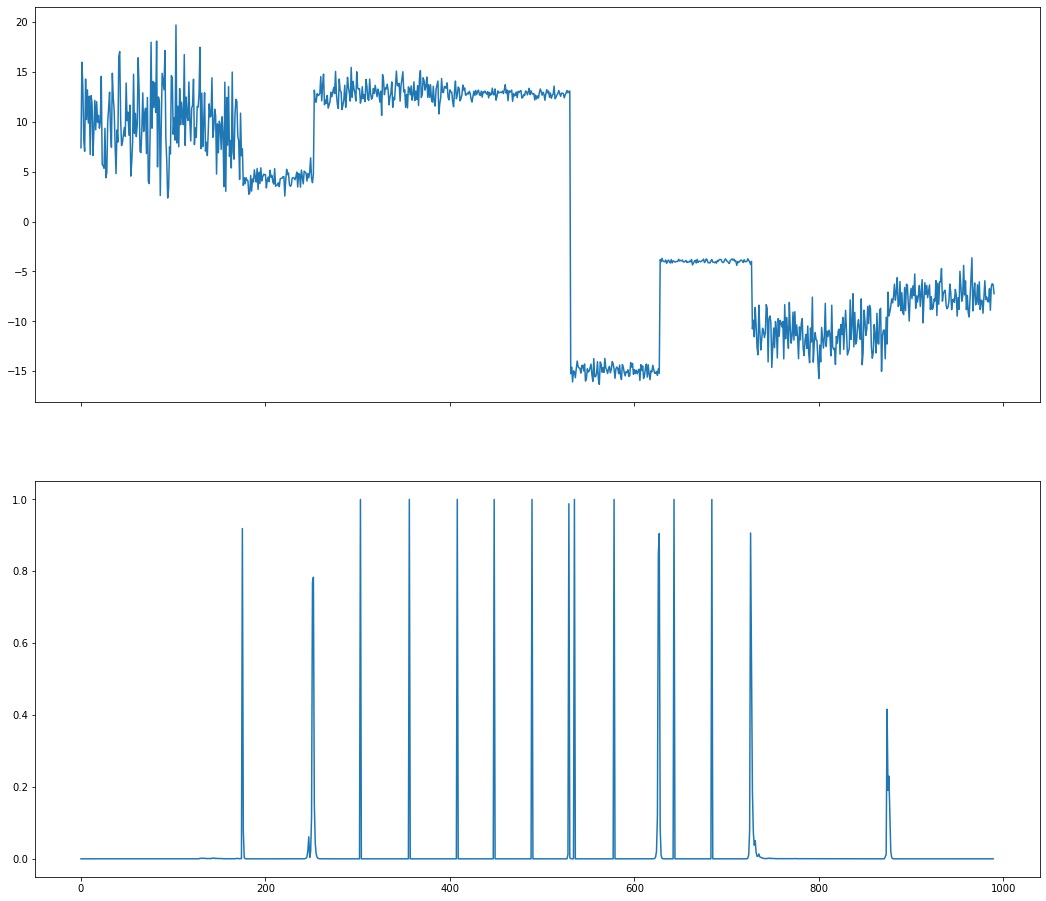

In [8]:
Q, P, Pcp = offline_changepoint_detection(data, prior_function, offline_ll.StudentT(), truncate=-10)
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
ax[0].plot(data[:])
ax[1].plot(np.exp(Pcp).sum(0))

With '-10' as the tranket value we can see there are more change points detected which should not be.

## Online Changepoint Detection
Let's assume the data points come in one after another and not as these nice batches. During the process you want to know if the new point has the same hyperparameter or different ones. You need an online changepoint detection.

Happily there is one, although it's interface is kind of suboptimal so far, in that it expects batches of data still and just assumes they drop in over time... I will change that at some point.

In [9]:
# Import the `constant_hazard` function from the `bayesian_changepoint_detection.hazard_functions` module
from bayesian_changepoint_detection.hazard_functions import constant_hazard

# Create a partial function `hazard_function` using `constant_hazard` with a fixed value for the parameter `r`
# The value of `lambda` is set to 250, which determines the average run length between changepoints
hazard_function = partial(constant_hazard, 250)

* The `constant_hazard` function is a simple hazard function that assumes a constant probability of a changepoint at each time step
* The `hazard_function` sets the value of the parameter `r` to 250, which means that the average run length between changepoints is 250 time steps
* The hazard function determines the probability of a changepoint at each time step given the past history of the time series
* A higher value of `r` corresponds to a longer average run length, which means that changepoints are less frequent

In [10]:
# Import the `online_changepoint_detection` function from the `bayesian_changepoint_detection.bayesian_models` module
from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection

# Import the `online_likelihoods` module from the `bayesian_changepoint_detection` package and give it an alias of `online_ll`
import bayesian_changepoint_detection.online_likelihoods as online_ll

# Call the `online_changepoint_detection` function with the following arguments:
# - `data`: the time series data to be analyzed
# - `hazard_function`: the hazard function that determines the probability of a changepoint at each time step given the past history of the time series
# - `online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)`: the likelihood function to use, which is a Student's t-distribution with known degrees of freedom and hyperparameters
R, maxes = online_changepoint_detection(data, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0))


* The `online_changepoint_detection` function is a Bayesian changepoint detection algorithm that performs online inference on a time series
* The algorithm estimates the probability of a changepoint at each time step using a Bayesian approach, and returns the most probable changepoint locations
* The `data` argument is the time series data to be analyzed
* The `hazard_function` argument is the hazard function that determines the probability of a changepoint at each time step given the past history of the time series
* The `online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)` argument specifies the likelihood function to use, which is a Student's t-distribution with known degrees of freedom and hyperparameters
* The function returns two variables: `R` and `maxes`
* `R` is a matrix of changepoint probabilities for each time step
* `maxes` is a vector of the most probable changepoint locations


The online version computes slightly different things. For each time step it returns the probability distribution over the length of the last sequence. E.g. R[7, 3] is the probability at time step 7 that the last sequence is already 3 time steps long. It also returns the MAP estimate at each timestep for convenience.

To plot the distributions we use a grey-scale colormap, black is zero, white 1. We also plot the probability at each time step for a sequence length of 0, i.e. the probability of the current time step to be a changepoint.

Because it's very hard to correctly evaluate a change after a single sample of a new distribution, we instead can "wait" for Nw samples and evalute the probability of a change happening Nw samples prior.

#### Lets visualise the change points along with the runlength distribution

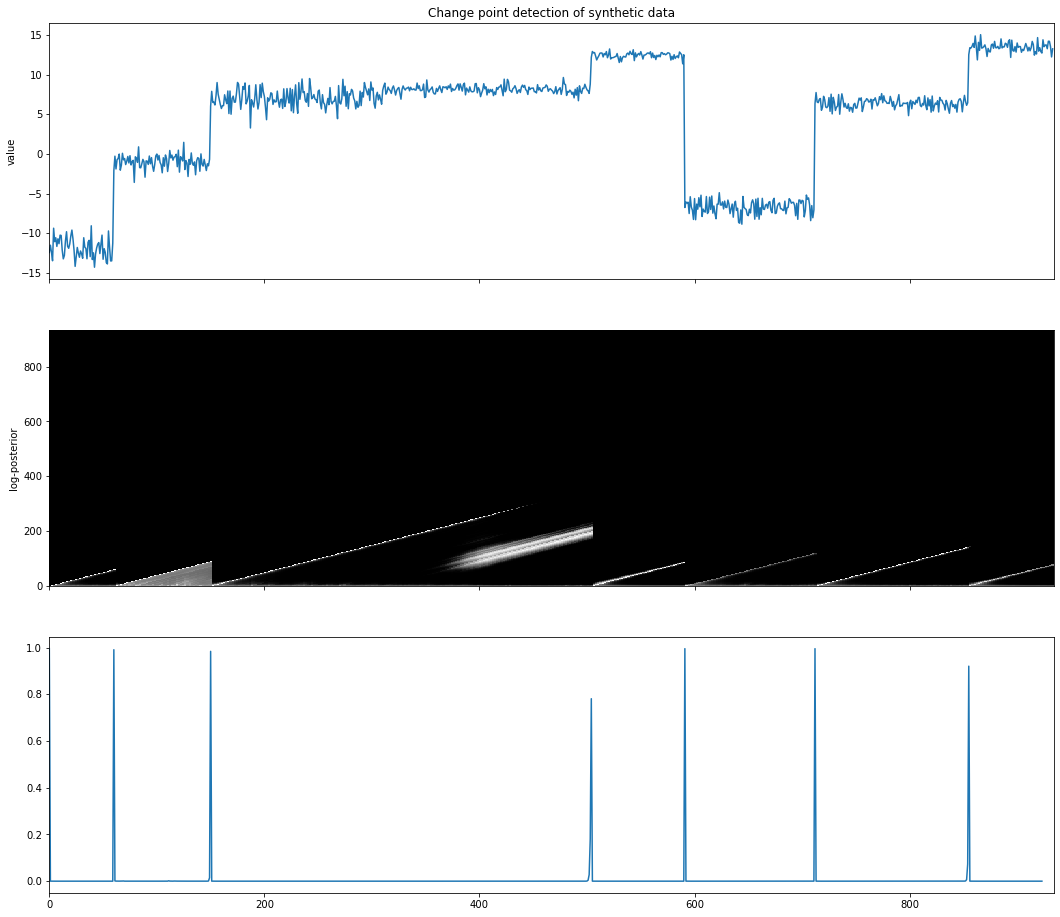

In [11]:
import matplotlib.cm as cm
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(data)
ax[0].set_title("Change point detection of synthetic data")
ax[0].set_ylabel("value")
sparsity = 2  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
ax[1].set_ylabel("log-posterior")
Nw=10
ax[2].plot(R[Nw,Nw:-1])

## Change point detection in Well-Log data set.

The well-log dataset contains 4050 observations of nuclear magnetic responses collected during well digging. The information is utilised to deduce the geophysical structure of the rock surrounding the well. The mean variations reflect the strata of the earth's crust. 

In [12]:
import pandas as pd
import numpy as np
# Define the file path and separator
file_path = 'well_log.txt'
separator = ','

# Read the text file into a pandas dataframe
df = pd.read_csv(file_path, sep=separator)

# Print the first few rows of the dataframe
print(df.head())

   Rsonance
0  133530.6
1  137119.1
2  133820.5
3  136014.3
4  133757.0


##### Preprocessing

We have used statndered scaler to scale the data, and modelled the data using univariate gauusian distribution which is simmilar as a student's T distribution with $\mu$ = 0, and 'var' = 1.

In [13]:
# Import standered Scaler
from sklearn.preprocessing import StandardScaler
well_scaled = StandardScaler().fit_transform(df)

In [14]:
# Not taking the whole data; we are taking a subset of the scaled dataset only.
well_scaled1 = np.array(well_scaled).reshape(well_scaled.shape[0],1)[1500:2700] 

In [15]:
# Call the `online_changepoint_detection as previous example
R, maxes = online_changepoint_detection(
    well_scaled1, hazard_function, online_ll.StudentT(alpha=.1, beta=0.01, kappa=1, mu=0 )
)

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

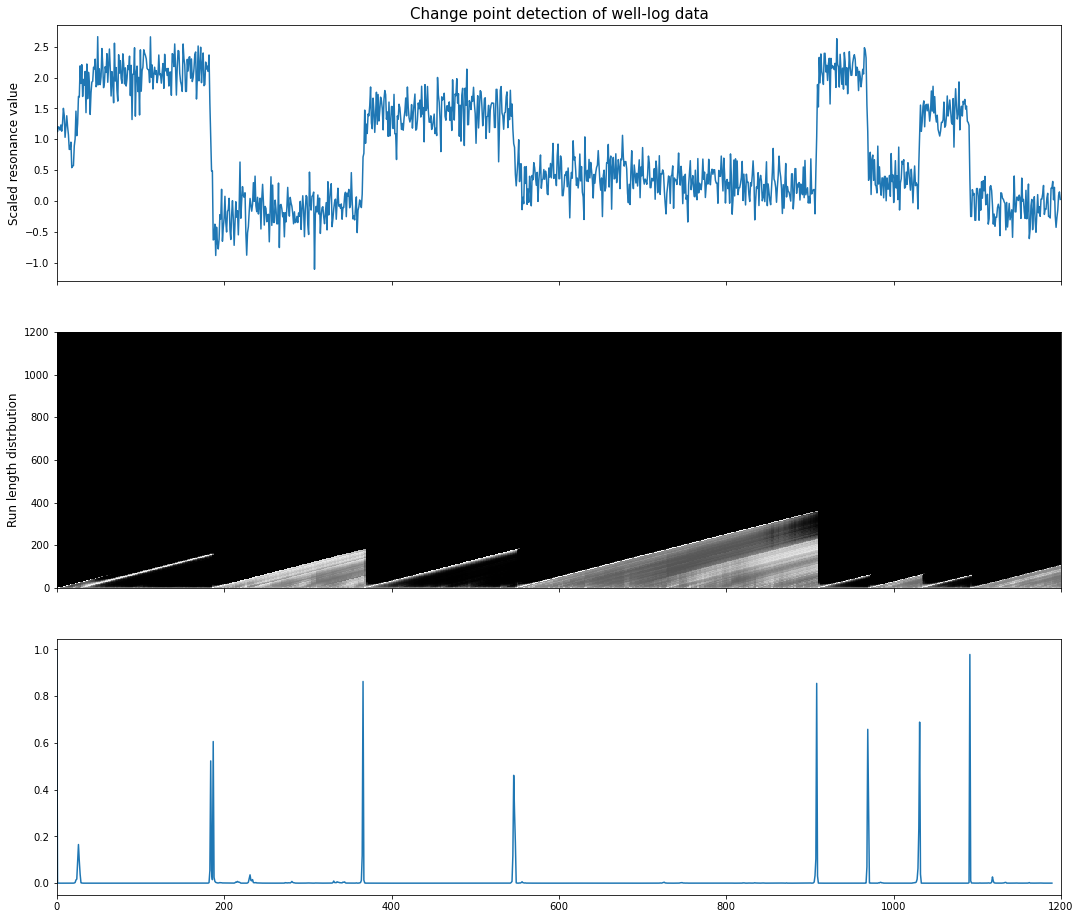

In [16]:
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(well_scaled1)
ax[0].set_title("Change point detection of well-log data",fontsize = 15)
ax[0].set_ylabel("Scaled resonance value",fontsize = 12)
sparsity = 2  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
ax[1].set_ylabel("Run length distrbution",fontsize = 12)

Nw=10
ax[2].plot(R[Nw,Nw:-1])
#ax[2].set_xticks(np.arange(1500, 27001))
plt.title

## Online Changepoint Detection with data with Poisson-gamma distribution

The only and major change compare to the previous one is the replacement of the Normal-gaussian posterior probablity distribution with Possion-gamma distribution
Here we have used Negative bionimial distribution as The negative binomial distribution was originally derived as a limiting case of the gamma-Poisson distribution

#### Create a synthtic data

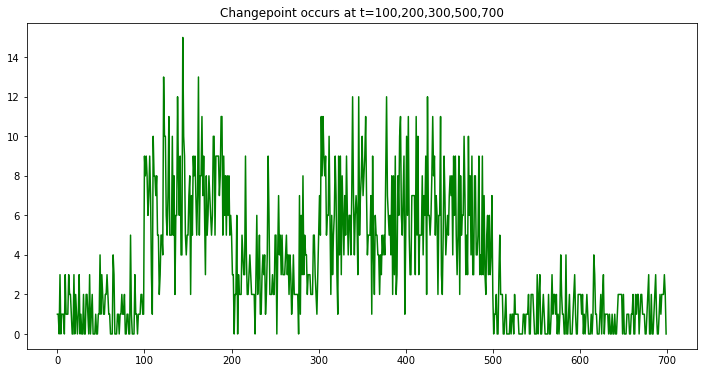

In [17]:
from scipy.stats import poisson
plt.figure(figsize = (12,6))
data = np.concatenate((poisson(1).rvs(100),poisson(7).rvs(100),poisson(3).rvs(100),poisson(6).rvs(200),poisson(1).rvs(200)))
ax=plt.plot(np.array(range(700)),data,color='green')
ax=plt.title('Changepoint occurs at t=100,200,300,500,700')

In [18]:
# Implementing the Online Change Point Detection algorithm with a lambda gap of 1000
hazard_function = partial(constant_hazard, 20) # Setting the new constant hazard
R, maxes = online_changepoint_detection(
    data, hazard_function, online_ll.Poisson(k=1, theta=1)
)

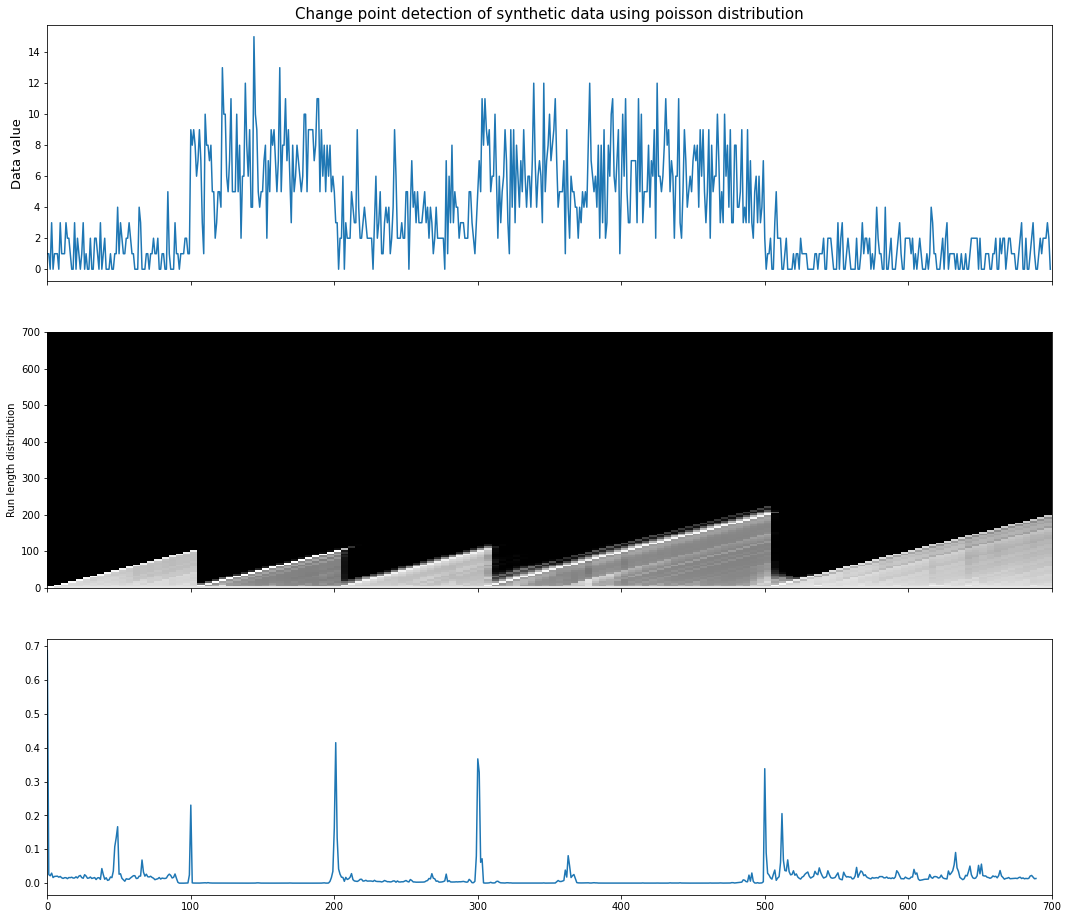

In [19]:
# Visualisation
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(data)
ax[0].set_title("Change point detection of synthetic data using poisson distribution",fontsize = 15)
ax[0].set_ylabel("Data value", fontsize = 13)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
ax[1].set_ylabel("Run length distribution")
Nw=10
ax[2].plot(R[Nw,Nw:-1])

## On Coal-mine disaster data

The coal-mine data are from between March 15, 1851, and March 22, 1962, and these are the dates of coal mine explosions that killed ten or more persons.
In this data, there are 191 responses. To use this data, we have processed it as the no of accidents that happened per week using the numpy and pandas libraries. Then found the cumulative number of accidents for every week starting from the 1st accident as 0 week. Then the changepoint of the local slop of the cumulative sum was tried to find.

#### Preprocessing

In [20]:
data_coal = np.loadtxt('coal_disasters.txt')
coal_disaster = pd.DataFrame(data_coal,columns = ['Month','Year', 'DayOfYear', 'Interval','Deaths'])
coal_disaster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      191 non-null    float64
 1   Year       191 non-null    float64
 2   DayOfYear  191 non-null    float64
 3   Interval   191 non-null    float64
 4   Deaths     191 non-null    float64
dtypes: float64(5)
memory usage: 7.6 KB


In [21]:
# Checking null value
coal_disaster.isnull().sum()

Month        0
Year         0
DayOfYear    0
Interval     0
Deaths       0
dtype: int64

In [22]:
coal_disaster.head()

,Month,Year,DayOfYear,Interval,Deaths
0,3.0,1851.0,74.0,0.0,61.0
1,8.0,1851.0,231.0,157.0,35.0
2,12.0,1851.0,354.0,123.0,52.0
3,12.0,1851.0,356.0,2.0,13.0
4,4.0,1852.0,115.0,124.0,12.0


In [23]:
# Give two new colums 'Date' and 'No.of death'
from datetime import datetime
coal_disaster['Date'] = 0
coal_disaster['no_accident'] = 1
for i in range(coal_disaster.shape[0]):
    coal_disaster['Date'][i]=datetime.strptime(str(int(coal_disaster['Year'][i])) + "-"
                                               + str(int(coal_disaster['DayOfYear'][i])), "%Y-%j").strftime("%m-%d-%Y")

C:\Users\krishnendu\AppData\Local\Temp\ipykernel_25416\487770993.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coal_disaster['Date'][i]=datetime.strptime(str(int(coal_disaster['Year'][i])) + "-"


In [24]:
coal_disaster['Date']= pd.to_datetime(coal_disaster['Date'])
coal_disaster =coal_disaster.set_index('Date')
coal_death = coal_disaster['no_accident']
coal_disaster_weekly = coal_death.resample('w').count() # Taking frequency as week
coal_disaster_weekly = pd.DataFrame(coal_disaster_weekly)
coal_disaster_weekly['No_cumsum']=coal_disaster_weekly['no_accident'].cumsum()

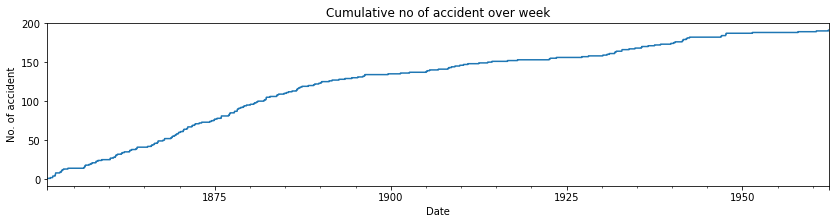

In [25]:
# Lets visualise the weekly cumcum
plt.figure(figsize=(14,3))
coal_disaster_weekly['No_cumsum'].plot()
plt.title("Cumulative no of accident over week")
plt.ylabel("No. of accident");

Calculate the local slope of cumlative sum of accidents, which indiactes the rate of accident.

In [26]:
slope = []
for i in range(4793):
    lw = coal_disaster_weekly['No_cumsum'][i]
    up =  coal_disaster_weekly['No_cumsum'][i+1000]
    sl = (up-lw)/1000
    slope.append(sl)
df_coal_mine_pg = np.array(slope).reshape(len(slope),1) ## taking as an array of the data points

In [27]:
# increase the scale of slopes to be captured properly with the algorithm
df_coal_mine_pg = df_coal_mine_pg*1000

In [28]:
# Implement the online changepoint detection
R, maxes = online_changepoint_detection(
    df_coal_mine_pg, hazard_function, online_ll.Poisson(k=1, theta=1)
)

Text(0, 0.5, 'Runlength distribution')

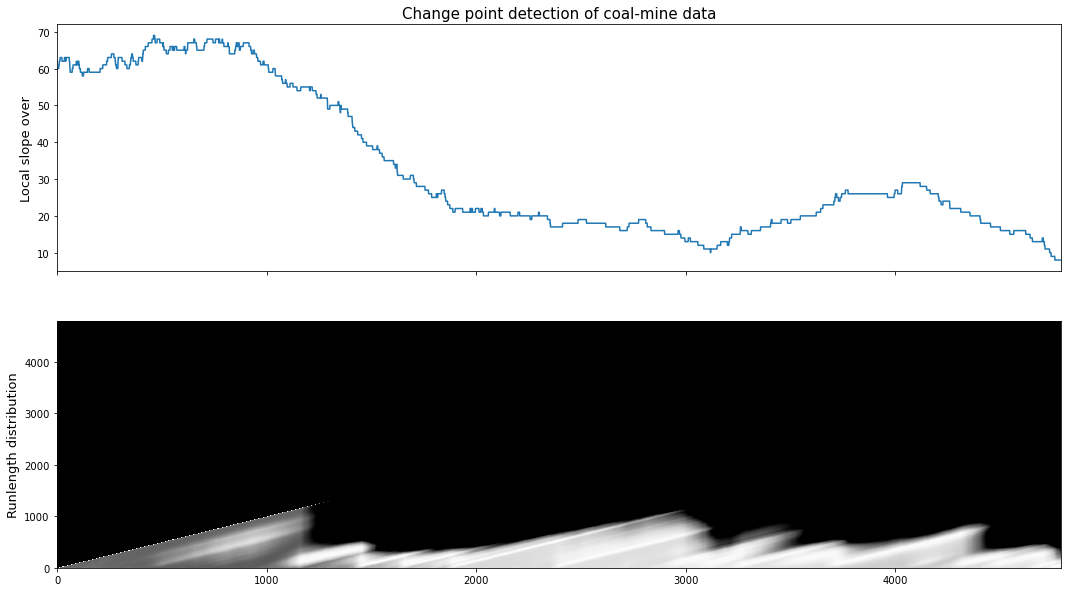

In [29]:
epsilon = 1e-40
fig, ax = plt.subplots(2, figsize=[18, 10], sharex=True)
ax[0].plot(df_coal_mine_pg)
ax[0].set_title("Change point detection of coal-mine data",fontsize = 15)
ax[0].set_ylabel("Local slope over", fontsize = 13)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[1].set_ylabel("Runlength distribution", fontsize = 13)

## Multivariate data

In [30]:

import pandas as pd
import numpy as np
# Define the file path and separator
file_path1 = 'FTT-USD.txt'
separator = ','

# Read the text file into a pandas dataframe
ftx = pd.DataFrame(pd.read_csv(file_path1, sep=separator))

# Print the first few rows of the dataframe
ftx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-13,41.435265,42.425529,40.703781,40.933903,40.933903,161102266
1,2022-01-14,40.931896,44.625141,40.789906,44.600353,44.600353,298873970
2,2022-01-15,44.629269,47.213104,44.435539,46.065502,46.065502,336785488
3,2022-01-16,46.059650,46.580048,45.289783,46.424992,46.424992,203763297
4,2022-01-17,46.438091,46.525822,43.999199,44.400253,44.400253,265485755


In [31]:
# Define the file path and separator
file_path2 = 'BTC-USD.txt'
separator = ','

# Read the text file into a pandas dataframe
btc = pd.DataFrame(pd.read_csv(file_path2, sep=separator))

# Print the first few rows of the dataframe
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-13,43946.742188,44278.421875,42447.042969,42591.570313,42591.570313,47691135082
1,2022-01-14,42598.871094,43346.687500,41982.617188,43099.699219,43099.699219,23577403399
2,2022-01-15,43101.898438,43724.671875,42669.035156,43177.398438,43177.398438,18371348298
3,2022-01-16,43172.039063,43436.808594,42691.023438,43113.878906,43113.878906,17902097845
4,2022-01-17,43118.121094,43179.390625,41680.320313,42250.550781,42250.550781,21690904261


In [32]:
start_date = '2022-10-01'
end_date = '2023-01-01'

ftx['Date'] = pd.to_datetime(ftx['Date'])
ftx.sort_values(by='Date', inplace=True)
ftx = ftx[(ftx['Date']>start_date)& (ftx['Date']<end_date)]

btc['Date'] = pd.to_datetime(btc['Date'])
btc.sort_values(by='Date', inplace=True)
btc = btc[(btc['Date']>start_date) & (btc['Date']<end_date)]

df_cryp = pd.merge(ftx[['Date','Open']],btc[['Date','Open']], on='Date')
df_cryp.columns =['date', 'ftx', 'btc']

data_cryp = df_cryp[['ftx','btc']].values
dates = df_cryp['date']

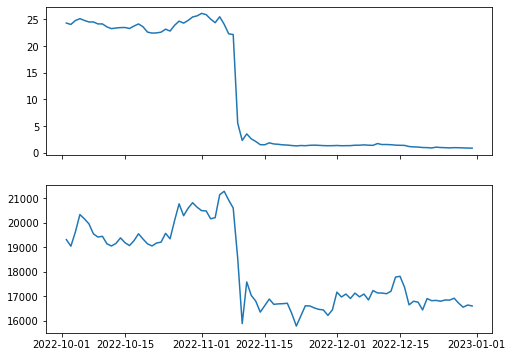

In [33]:
fig ,ax = plt.subplots(2, figsize=(8,6),sharex=True)
ax[0].plot(dates,data_cryp[:,0])
ax[1].plot(dates,data_cryp[:,1])

In [34]:
from sklearn.preprocessing import StandardScaler
data_cryp_scaled = StandardScaler().fit_transform(data_cryp)

In [35]:
from itertools import islice
from numpy.linalg import inv

In [36]:
hazard_function = partial(constant_hazard, 50)

In [37]:
R, maxes = online_changepoint_detection(
    data_cryp_scaled, hazard_function, online_ll.MultivariateT(dims = 2)
)

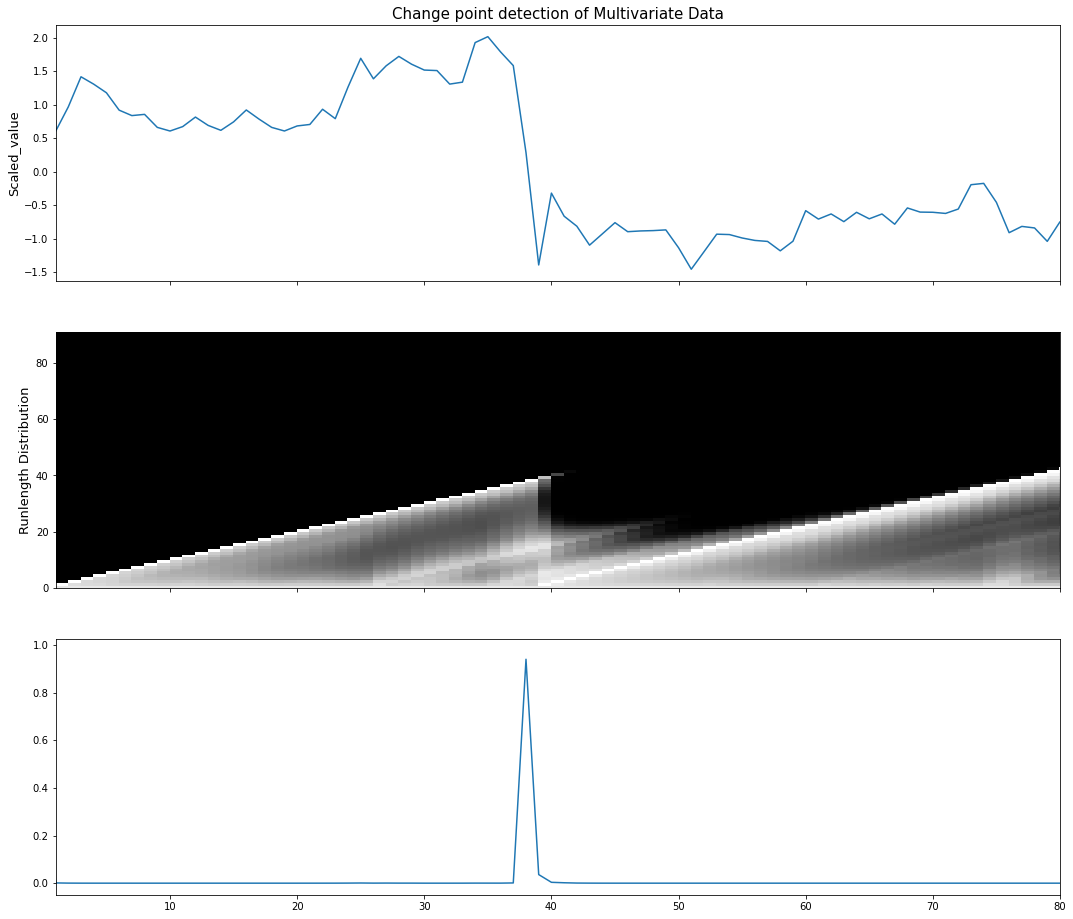

In [38]:
import matplotlib.cm as cm
epsilon = 1e-10
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(data_cryp_scaled[:,1])
ax[0].set_title("Change point detection of Multivariate Data",fontsize = 15)
ax[0].set_ylabel("Scaled_value",fontsize = 13)
sparsity = 1  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
ax[1].set_ylabel("Runlength Distribution",fontsize = 13)
Nw=10
ax[2].plot(R[Nw,Nw:-1])
ax[2].set_xlim(1,80);